In [ ]:
!pip install emoji

In [17]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [ ]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

In [10]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [12]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [13]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message

In [14]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [15]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [8]:
from google.colab import files
uploaded = files.upload()

Saving WhatsApp Chat with Bholatto-Bholatto.txt to WhatsApp Chat with Bholatto-Bholatto.txt


In [18]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = "WhatsApp Chat with Bholatto-Bholatto.txt" 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

2019/12/26, 23:53 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [19]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [22]:
df.tail(2)

,Date,Time,Author,Message,emoji,urlcount
5621,2020-10-23,10:29,Vikela,Yu are putting that person at risk as well......,[],0
5622,2020-10-23,10:35,Malu,It is someone's wife 🤦🏽‍♂,[🤦🏽‍♂],0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5541 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5541 non-null   datetime64[ns]
 1   Time      5541 non-null   object        
 2   Author    5541 non-null   object        
 3   Message   5541 non-null   object        
 4   emoji     5541 non-null   object        
 5   urlcount  5541 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 303.0+ KB


## Printing Participants

In [23]:
df.Author.unique()

array(['Taps', 'Malu', 'Mbuyi', 'Christian', 'Sthwa', 'Vikela',
       '+27 73 201 7527', '+263 77 292 8937'], dtype=object)

In [24]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5541 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5541 non-null   datetime64[ns]
 1   Time      5541 non-null   object        
 2   Author    5541 non-null   object        
 3   Message   5541 non-null   object        
 4   emoji     5541 non-null   object        
 5   urlcount  5541 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 303.0+ KB


In [25]:
df.Author.unique()

array(['Taps', 'Malu', 'Mbuyi', 'Christian', 'Sthwa', 'Vikela',
       '+27 73 201 7527', '+263 77 292 8937'], dtype=object)

## Group Wise Stats

In [26]:
total_messages = df.shape[0]
print(total_messages)

5541


## Total Media Messages

In [27]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [28]:
emojis = sum(df['emoji'].str.len())
print(emojis)

3110


In [30]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [31]:
links = np.sum(df.urlcount)

In [32]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 5541
Media: 0
Emojis: 3110
Links: 5


## Separating the Media and Text Messages

In [33]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [34]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3998 entries, 0 to 5622
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3998 non-null   datetime64[ns]
 1   Time      3998 non-null   object        
 2   Author    3998 non-null   object        
 3   Message   3998 non-null   object        
 4   emoji     3998 non-null   object        
 5   urlcount  3998 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 218.6+ KB


In [35]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [38]:
messages_df.tail(5)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount
5616,2020-10-23,09:52,Malu,Guys im with the wife here. He deserved it man.,[],0,48,11,1
5619,2020-10-23,10:19,Vikela,But why confess and give names 🤦🏽‍♂️,[🤦🏽‍♂️],0,37,8,1
5620,2020-10-23,10:25,Taps,Eish papa kana mamega mumba waiswa PA corner ...,[],0,114,22,1
5621,2020-10-23,10:29,Vikela,Yu are putting that person at risk as well......,[],0,265,42,1
5622,2020-10-23,10:35,Malu,It is someone's wife 🤦🏽‍♂,[🤦🏽‍♂],0,26,6,1


In [39]:
messages_df["emojicount"]= df['emoji'].str.len()

## Author Wise Stats

In [40]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(link_messages[link_messages['Author'] == l[i]]["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Taps -
Messages Sent 1225
Words per message 8.811428571428571
Media Messages Sent 451
Emojis Sent 861
Links Sent 2

Stats of Malu -
Messages Sent 1255
Words per message 7.517131474103586
Media Messages Sent 642
Emojis Sent 1056
Links Sent 2

Stats of Mbuyi -
Messages Sent 545
Words per message 11.289908256880734
Media Messages Sent 61
Emojis Sent 655
Links Sent 1

Stats of Sthwa -
Messages Sent 415
Words per message 7.048192771084337
Media Messages Sent 129
Emojis Sent 61
Links Sent 0

Stats of Vikela -
Messages Sent 431
Words per message 8.793503480278423
Media Messages Sent 228
Emojis Sent 374
Links Sent 0

Stats of Christian -
Messages Sent 60
Words per message 4.383333333333334
Media Messages Sent 17
Emojis Sent 70
Links Sent 0

Stats of +27 73 201 7527 -
Messages Sent 20
Words per message 10.4
Media Messages Sent 0
Emojis Sent 22
Links Sent 0

Stats of +263 77 292 8937 -
Messages Sent 47
Words per message 7.085106382978723
Media Messages Sent 7
Emojis Sent 11
Links Sent 0

## Most Emojis Used in the Group

### Emoji Stats

#### Unique Emojis used in the group

In [41]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

113


### Most Emoji Used

In [42]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('🤣', 1822), ('😂', 374), ('👏🏾', 82), ('🙆🏻\u200d♂', 61), ('🤦🏽\u200d♂️', 42), ('🙈', 37), ('⚽', 36), ('😭', 34), ('🤦🏽\u200d♂', 33), ('🙏🏼', 25), ('⚰️', 24), ('🙆🏽\u200d♂', 23), ('🔥', 23), ('👀', 21), ('🤗', 20), ('🤷🏾\u200d♂️', 19), ('🤦🏾\u200d♂️', 17), ('🤷🏾\u200d♂', 17), ('🙆🏽\u200d♂️', 16), ('🤷🏽\u200d♂️', 16), ('💀', 15), ('🤦🏿\u200d♂', 14), ('🤔', 13), ('😒', 13), ('🙏🏽', 12), ('🙏🏾', 11), ('🤝🏾', 11), ('👌🏾', 11), ('👌🏽', 10), ('😊', 10), ('👆🏻', 8), ('🙌🏾', 8), ('😃', 8), ('😔', 8), ('😜', 7), ('⬆️', 7), ('😉', 7), ('\U0001f97a', 7), ('😌', 6), ('😫', 6), ('🙆🏾\u200d♂️', 6), ('😅', 6), ('😍', 6), ('😆', 6), ('🙅🏽\u200d♂️', 6), ('😘', 6), ('👊🏼', 5), ('💯', 5), ('😹', 5), ('😄', 5), ('😀', 4), ('👏🏽', 4), ('😑', 4), ('🇿🇼', 4), ('\U0001f928', 4), ('🏃🏽', 4), ('🤙🏼', 4), ('🚩', 3), ('✋🏾', 3), ('🤞🏾', 3), ('😩', 3), ('👴🏽', 3), ('🙁', 3), ('\U0001f92e', 3), ('😳', 3), ('😁', 2), ('🥃', 2), ('🙄', 2), ('💔', 2), ('👍🏽', 2), ('✊🏾', 2), ('😗', 2), ('😶', 2), ('😎', 2), ('🎂', 2), ('🏃\u200d♂️', 2), ('💙', 2), ('👊🏽', 2), ('🚨', 2), ('✌🏾', 2), ('😱',

In [43]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,🤣,1822
1,😂,374
2,👏🏾,82
3,🙆🏻‍♂,61
4,🤦🏽‍♂️,42
...,...,...
108,🙏🏻,1
109,🙂,1
110,☹️,1
111,💪🏽,1


### Emoji Distribution

In [44]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### Person Wise Emoji Distribution

In [45]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for Taps


Emoji Distribution for Malu


Emoji Distribution for Mbuyi


Emoji Distribution for Sthwa


Emoji Distribution for Vikela


Emoji Distribution for Christian


Emoji Distribution for +27 73 201 7527


Emoji Distribution for +263 77 292 8937


## More Stats

### Day Wise Distribution

In [46]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [47]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

## Number of messages as time moves on

In [48]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [49]:
date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

## Chatter

In [51]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

## When group members are most active

Text(0, 0.5, 'Time')

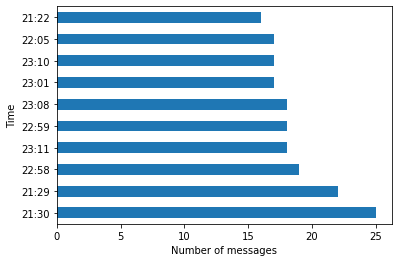

In [52]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

## The most happening day was 

2020-06-25    124
2020-07-02    110
2020-10-09    108
2020-07-22     80
2020-07-12     78
             ... 
2020-08-22      1
2020-04-23      1
2020-08-06      1
2020-04-15      1
2020-04-06      1
Name: Date, Length: 172, dtype: int64


Text(0, 0.5, 'Date')

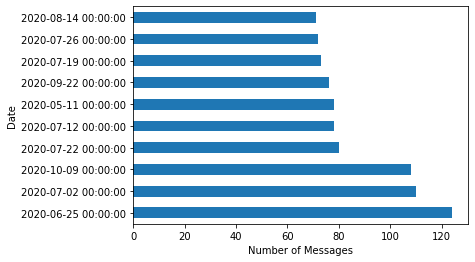

In [53]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### Message having the maximum number of words

In [54]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2020-10-07 00:00:00
Time                                                        17:36
Author                                                      Mbuyi
Message          I don't know if i should be disgusted or disa...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2037
Word_Count                                                    366
MessageCount                                                    1
emojicount                                                      0
Name: 4816, dtype: object

### Word Cloud

In [55]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 162558 words in all the messages.


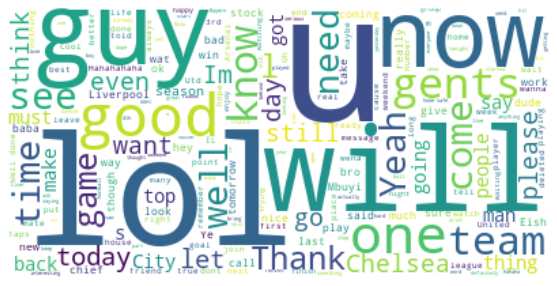

In [59]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Author wise word cloud


Author name Taps


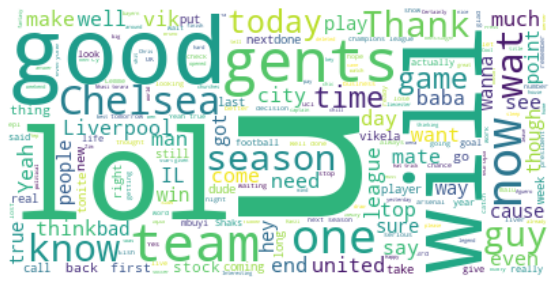

Author name Malu


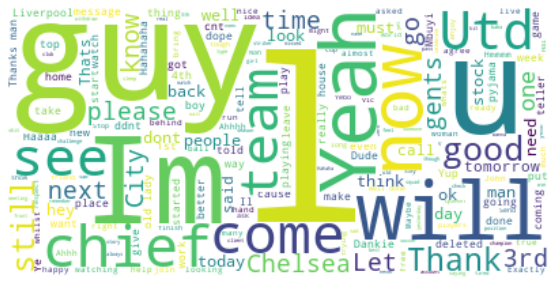

Author name Mbuyi


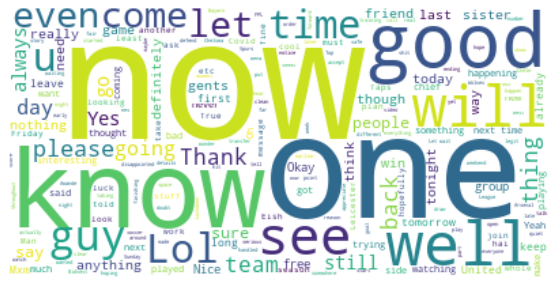

Author name Sthwa


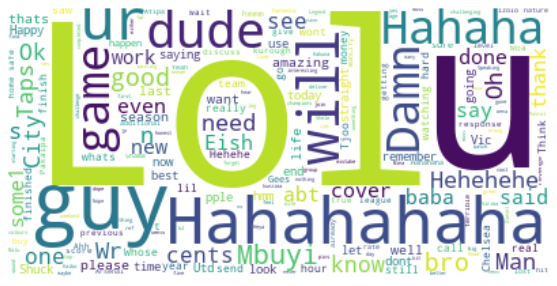

Author name Vikela


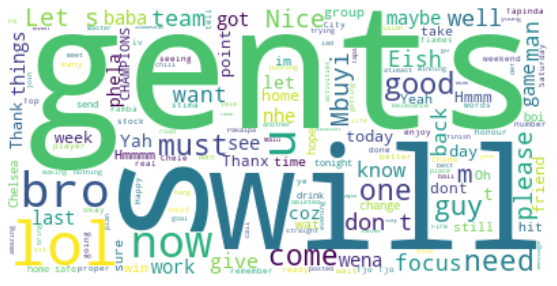

Author name Christian


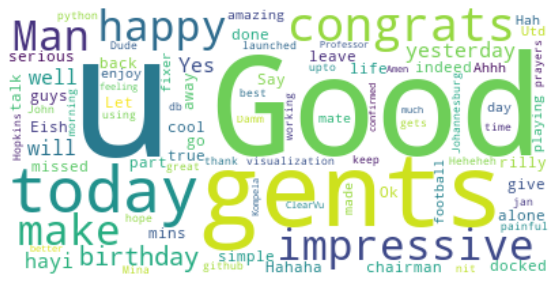

Author name +27 73 201 7527


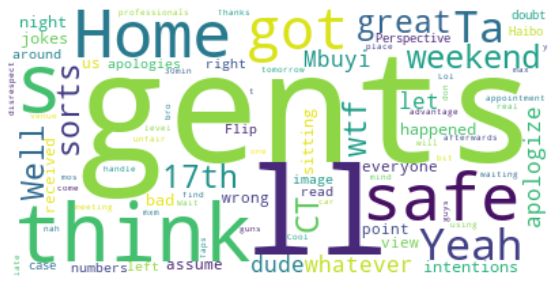

Author name +263 77 292 8937


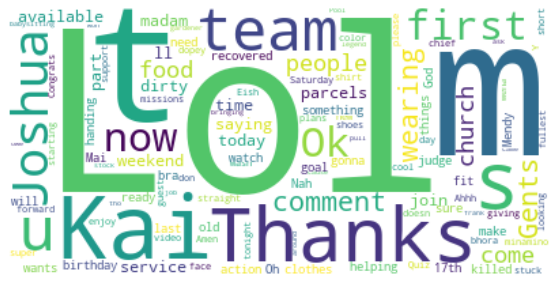

In [60]:
 l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
  # Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()